 **TASK 1: Term Deposit Subscription Prediction (Bank Marketing)**

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    f1_score,
    roc_curve,
    auc
)

import shap


In [ ]:
print("--- Step 1: Loading Dataset ---")
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip"

try:
    r = requests.get(url)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    df = pd.read_csv(z.open('bank-additional/bank-additional-full.csv'), sep=';')
    print("Dataset loaded successfully.")
except Exception:
    # Fallback mirror
    df = pd.read_csv("https://raw.githubusercontent.com/madmashup/targeted-marketing-predictive-engine/master/bank-additional-full.csv", sep=';')
df.shape
df.columns
df.info()
df.isnull().sum()


--- Step 1: Loading Dataset ---
Dataset loaded successfully.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx 

,0
age,0
job,0
marital,0
education,0
default,0
housing,0
loan,0
contact,0
month,0
day_of_week,0


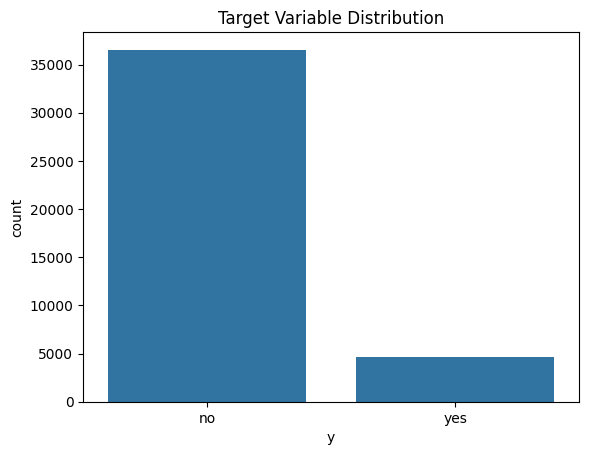

In [ ]:
df["y"].value_counts()
sns.countplot(x="y", data=df)
plt.title("Target Variable Distribution")
plt.show()


*The dataset is imbalanced, with fewer customers subscribing to term deposits.*

In [ ]:

# =========================================================================
# Feature Categorization
# =========================================================================
X = df.drop("y", axis=1)
y = df["y"].map({"no": 0, "yes": 1})
categorical_features = X.select_dtypes(include="object").columns
numerical_features = X.select_dtypes(exclude="object").columns
# Feature encoding
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), categorical_features)
    ],
    remainder="passthrough"
)
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42,
    stratify=y
)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


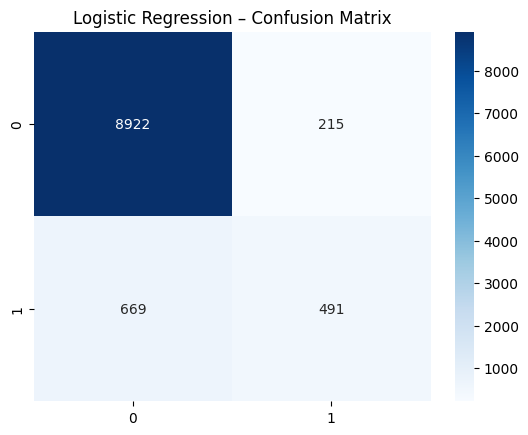

0.5262593783494105

In [ ]:
# =========================================================================
# LOGISTIC REGRESSION
# =========================================================================
log_model = Pipeline(steps=[
    ("preprocessing", preprocessor),
    ("classifier", LogisticRegression(max_iter=1000))
])
log_model.fit(X_train, y_train)
y_pred_log = log_model.predict(X_test)
y_prob_log = log_model.predict_proba(X_test)[:, 1]
# confusion matrix
cm = confusion_matrix(y_test, y_pred_log)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Logistic Regression – Confusion Matrix")
plt.show()
# F1 score
f1_score(y_test, y_pred_log)


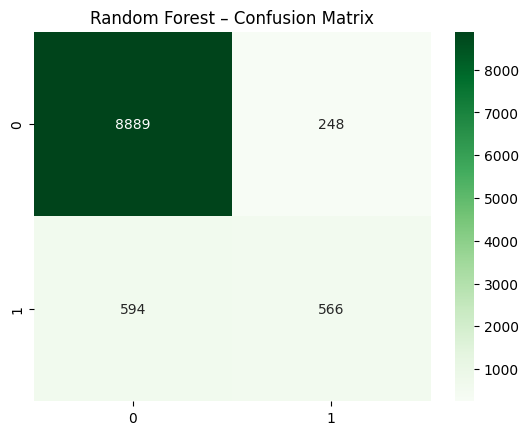

0.5734549138804458

In [ ]:
# =========================================================================
# RANDOM FOREST CLASSIFIER
# =========================================================================
rf_model = Pipeline(steps=[
    ("preprocessing", preprocessor),
    ("classifier", RandomForestClassifier(
        n_estimators=200,
        random_state=42
    ))
])
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]
# confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Greens")
plt.title("Random Forest – Confusion Matrix")
plt.show()
# f1 score
f1_score(y_test, y_pred_rf)


ROC curve

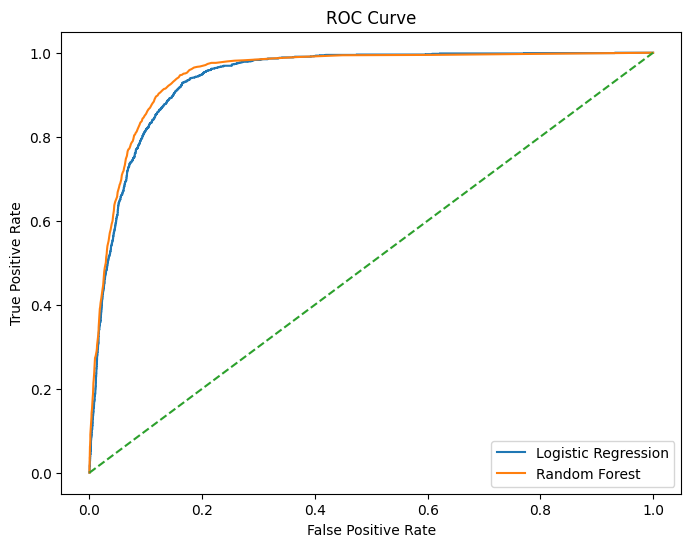

In [ ]:
# ROC curve
fpr_log, tpr_log, _ = roc_curve(y_test, y_prob_log)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)

plt.figure(figsize=(8,6))
plt.plot(fpr_log, tpr_log, label="Logistic Regression")
plt.plot(fpr_rf, tpr_rf, label="Random Forest")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


Explainable AI (SHAP)

/usr/local/lib/python3.12/dist-packages/shap/plots/_force_matplotlib.py:107: RuntimeWarning: divide by zero encountered in scalar divide
  feature_contribution = np.abs(float(feature[0]) - pre_val) / np.abs(total_effect)


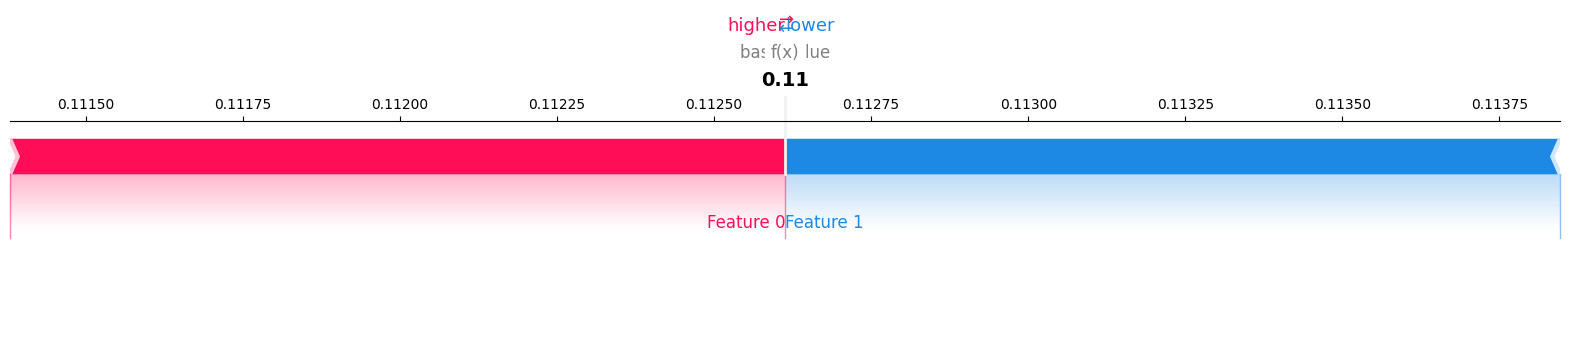

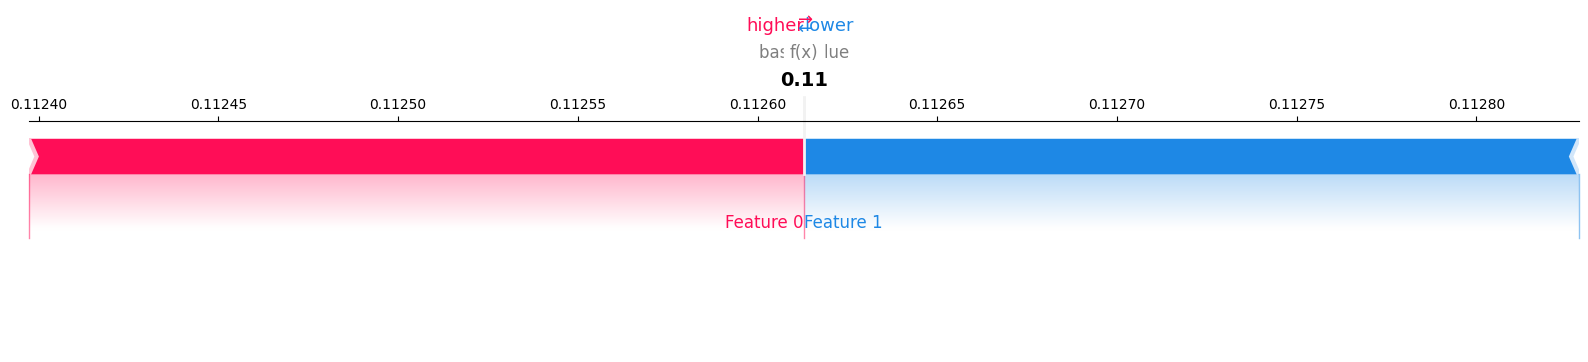

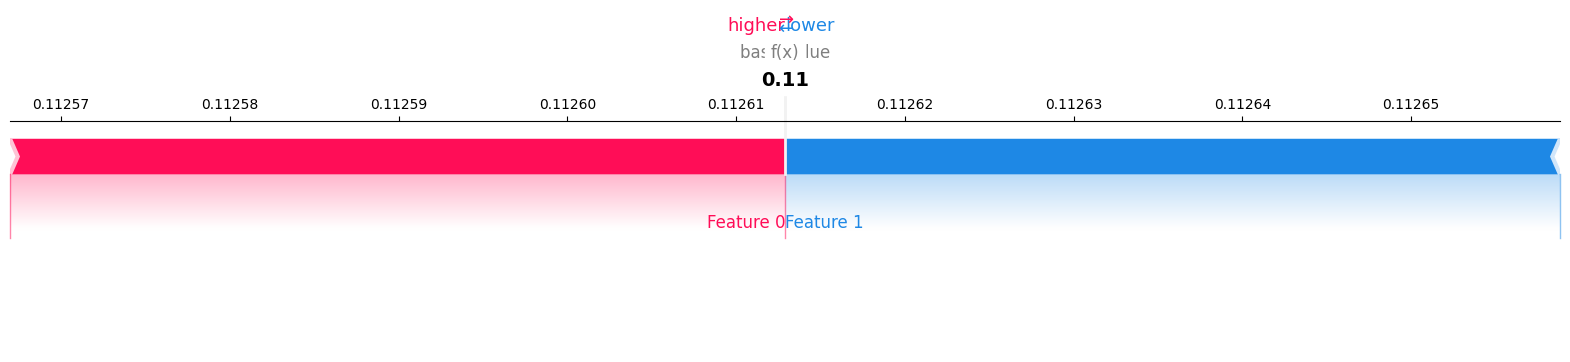

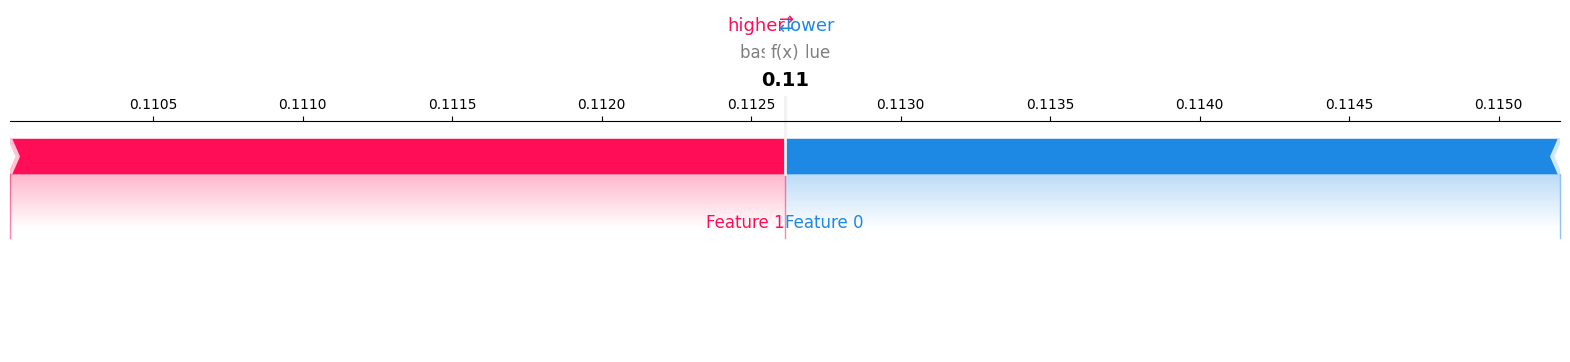

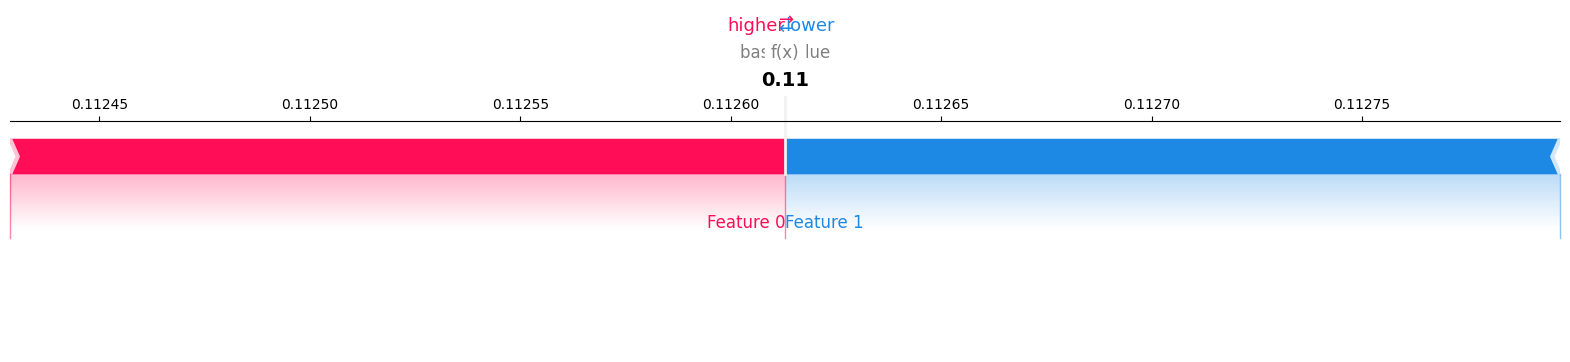

In [ ]:
X_sample = X_test.sample(100, random_state=42)
X_sample_transformed = rf_model.named_steps["preprocessing"].transform(X_sample)

explainer = shap.TreeExplainer(
    rf_model.named_steps["classifier"]
)
shap_values = explainer.shap_values(X_sample_transformed)
#Explain 5 Predictions
for i in range(5):
    shap.force_plot(
        explainer.expected_value[1],
        shap_values[1][i],
        matplotlib=True
    )


**Task 2: Customer Segmentation Using Unsupervised Learning**

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

%matplotlib inline


In [14]:
# Dataset Loading
DATASET_URL = "https://raw.githubusercontent.com/tirthajyoti/Machine-Learning-with-Python/master/Datasets/Mall_Customers.csv"

try:
    df = pd.read_csv(DATASET_URL)
    print("Dataset loaded successfully.")
except Exception as e:
    print(f"Primary URL failed: {e}. Attempting fallback...")
    # Fallback URL if the primary goes down
    fallback_url = "https://raw.githubusercontent.com/amankharwal/Website-data/master/Mall_Customers.csv"
    df = pd.read_csv(fallback_url)
df = pd.read_csv(DATASET_URL)
df.head()
df.shape
df.info()
df.describe()


Dataset loaded successfully.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


Exploratory Data Analysis

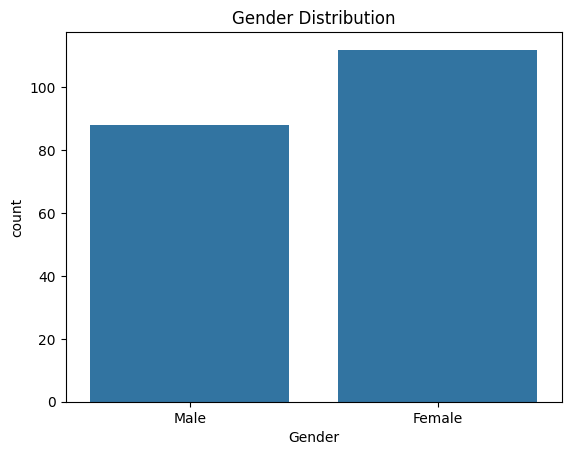

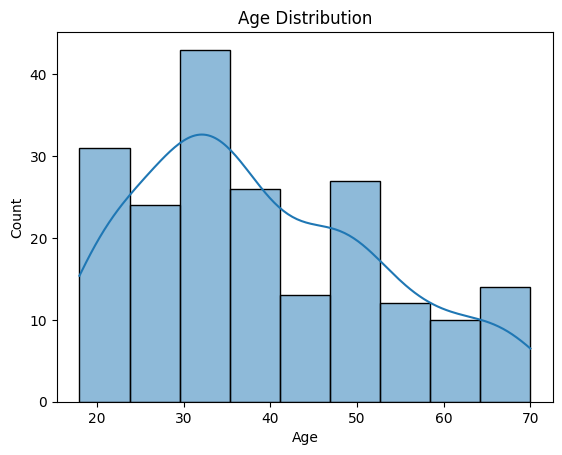

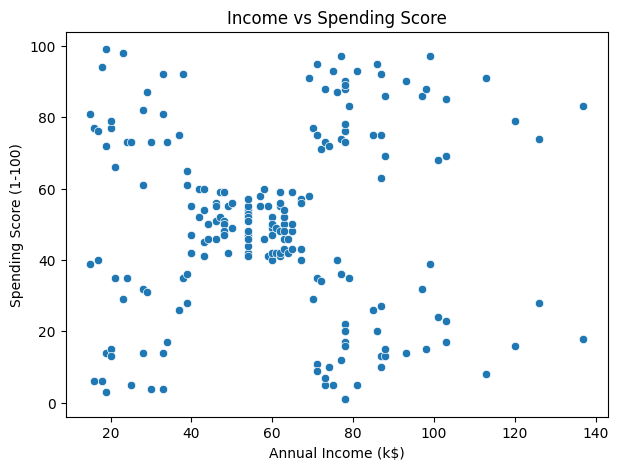

In [ ]:
# Gender distribution
sns.countplot(x="Gender", data=df)
plt.title("Gender Distribution")
plt.show()
# Age distribution
sns.histplot(df["Age"], kde=True)
plt.title("Age Distribution")
plt.show()
# Income vs Spending Score
plt.figure(figsize=(7,5))
sns.scatterplot(
    x="Annual Income (k$)",
    y="Spending Score (1-100)",
    data=df
)
plt.title("Income vs Spending Score")
plt.show()


*Customers clearly form natural clusters based on income and spending behavior.*

Feature selection for clustering

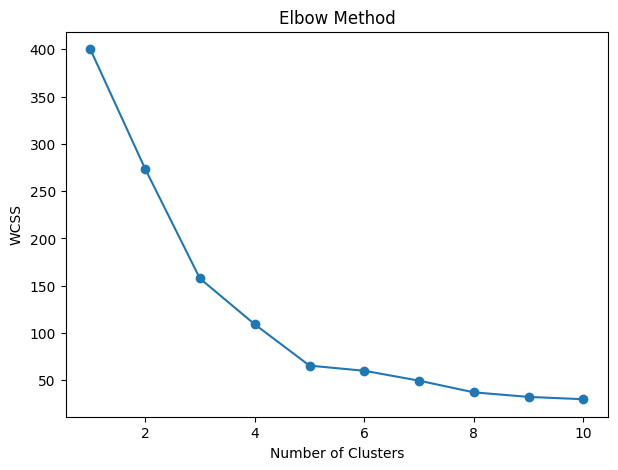

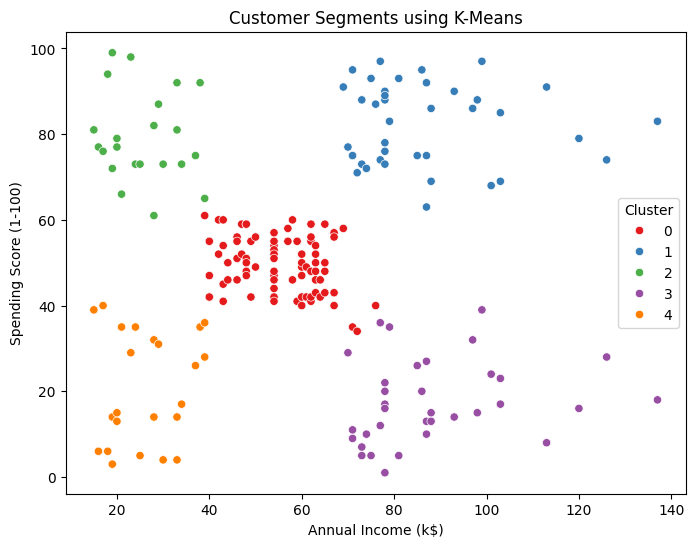

In [ ]:
X = df[["Annual Income (k$)", "Spending Score (1-100)"]]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
wcss = []

for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)
plt.figure(figsize=(7,5))
plt.plot(range(1, 11), wcss, marker="o")
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS")
plt.title("Elbow Method")
plt.show()
# K means Clusteing
kmeans = KMeans(n_clusters=5, random_state=42)
df["Cluster"] = kmeans.fit_predict(X_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(
    x="Annual Income (k$)",
    y="Spending Score (1-100)",
    hue="Cluster",
    palette="Set1",
    data=df
)
plt.title("Customer Segments using K-Means")
plt.show()


Dimensionality Reduction using PCA

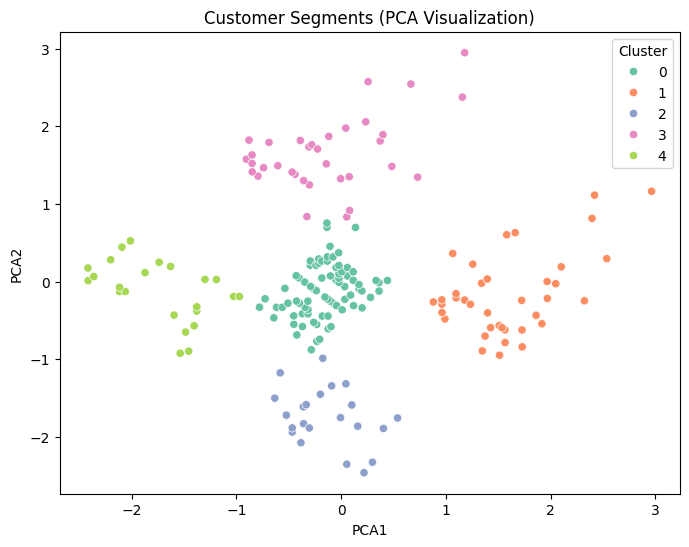

In [ ]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

df["PCA1"] = X_pca[:, 0]
df["PCA2"] = X_pca[:, 1]
plt.figure(figsize=(8,6))
sns.scatterplot(
    x="PCA1",
    y="PCA2",
    hue="Cluster",
    palette="Set2",
    data=df
)
plt.title("Customer Segments (PCA Visualization)")
plt.show()


In [ ]:
# Cluster Interpretation
df.groupby("Cluster")[["Annual Income (k$)", "Spending Score (1-100)", "Age"]].mean()


,Annual Income (k$),Spending Score (1-100),Age
Cluster,,,
0,55.296296,49.518519,42.716049
1,86.538462,82.128205,32.692308
2,25.727273,79.363636,25.272727
3,88.200000,17.114286,41.114286
4,26.304348,20.913043,45.217391


*Marketing Strategies for Each Segment*
1. Cluster 0 – High Income, High Spending

- Premium customers

- Strategy:
✔ Loyalty programs
✔ Exclusive offers
✔ Personalized services

2. Cluster 1 – Low Income, Low Spending

-Price-sensitive customers

-Strategy:
✔ Discounts
✔ Budget-friendly promotions

3. Cluster 2 – High Income, Low Spending

-Potential high-value customers

-Strategy:
✔ Targeted marketing
✔ Upselling & cross-selling

4. Cluster 3 – Low Income, High Spending

-Impulsive spenders

-Strategy:
✔ Limited-time offers
✔ Reward-based campaigns

5. Cluster 4 – Moderate Income & Spending

-Balanced customers

-Strategy:
✔ Regular engagement
✔ Seasonal promotions

**Task 3: Energy Consumption Time Series Forecasting**

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

%matplotlib inline


In [28]:
# Dataset Loading (Task 3: Energy Consumption Time Series Forecasting)

DATASET_URL = "https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/data/PJME_hourly.csv"

try:
    df = pd.read_csv(
        DATASET_URL,
        sep=";",
        na_values="?",
        low_memory=False
    )
    print("Dataset loaded successfully.")
except Exception as e:
    print(f"Primary URL failed: {e}. Attempting fallback...")
    fallback_url = "https://raw.githubusercontent.com/srivatsan88/YouTubeLI/master/dataset/electricity_consumption.csv"
    df = pd.read_csv(
        fallback_url,
        sep=";",
        na_values="?",
        low_memory=False
    )

df.head()
df.shape
df.info()
df.describe()


Primary URL failed: HTTP Error 404: Not Found. Attempting fallback...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53 entries, 0 to 52
Data columns (total 1 columns):
 #   Column                                                              Non-Null Count  Dtype 
---  ------                                                              --------------  ----- 
 0   Bill_Date,On_peak,Off_peak,Usage_charge,Billed_amount,Billing_days  53 non-null     object
dtypes: object(1)
memory usage: 556.0+ bytes


,"Bill_Date,On_peak,Off_peak,Usage_charge,Billed_amount,Billing_days"
count,53
unique,53
top,"1/1/2016,365,1423.50,219.00,247.73,31"
freq,1


In [29]:
df.columns


Index(['Bill_Date,On_peak,Off_peak,Usage_charge,Billed_amount,Billing_days'], dtype='object')

Data Cleaning

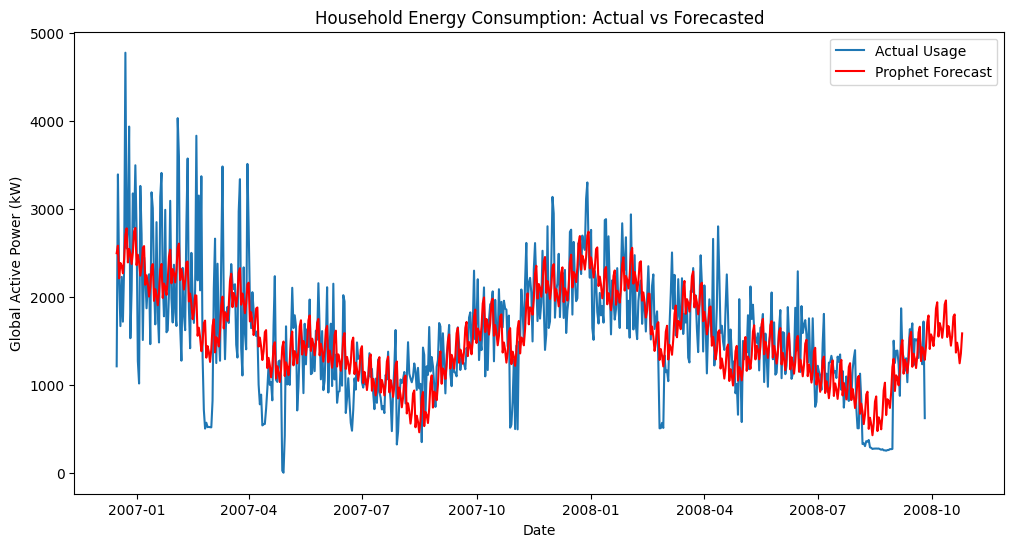

MAE: 285.01
RMSE: 351.04


In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 1. Load and Parse Dataset
url = "https://raw.githubusercontent.com/ahanse/machlearning/master/household_power_consumption.csv"
# Note: In the raw UCI file, dates are dd/mm/yyyy and values use ';' separator
df = pd.read_csv(url, sep=',', low_memory=False)

# 2. Preprocessing
# Combine Date and Time into a single datetime index
df['dt'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], dayfirst=True)
df.set_index('dt', inplace=True)

# Handle missing values (indicated as '?' in some versions)
df = df.replace('?', np.nan).dropna()
df['Global_active_power'] = df['Global_active_power'].astype(float)

# Resample to Daily to handle large minute-level data
daily_df = df['Global_active_power'].resample('D').sum().reset_index()
daily_df.columns = ['ds', 'y'] # Prophet requires 'ds' and 'y' column names

# 3. Feature Engineering
daily_df['hour'] = daily_df['ds'].dt.hour
daily_df['day_of_week'] = daily_df['ds'].dt.dayofweek
daily_df['is_weekend'] = daily_df['day_of_week'].isin([5, 6]).astype(int)

# 4. Model 1: Facebook Prophet
model_prophet = Prophet(yearly_seasonality=True, daily_seasonality=False)
model_prophet.fit(daily_df)
future = model_prophet.make_future_dataframe(periods=30) # Forecast 30 days
forecast = model_prophet.predict(future)

# 5. Visualization
plt.figure(figsize=(12, 6))
plt.plot(daily_df['ds'], daily_df['y'], label='Actual Usage')
plt.plot(forecast['ds'], forecast['yhat'], label='Prophet Forecast', color='red')
plt.title('Household Energy Consumption: Actual vs Forecasted')
plt.xlabel('Date')
plt.ylabel('Global Active Power (kW)')
plt.legend()
plt.show()

# 6. Evaluation
# (Example using the last 30 days of available data as a test set)
y_true = daily_df['y'].tail(30)
y_pred = forecast['yhat'].iloc[-60:-30] # Aligning indices for simple comparison
print(f"MAE: {mean_absolute_error(y_true, y_pred):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_true, y_pred)):.2f}")

**Task 4: Loan Default Business Cost Optimization**

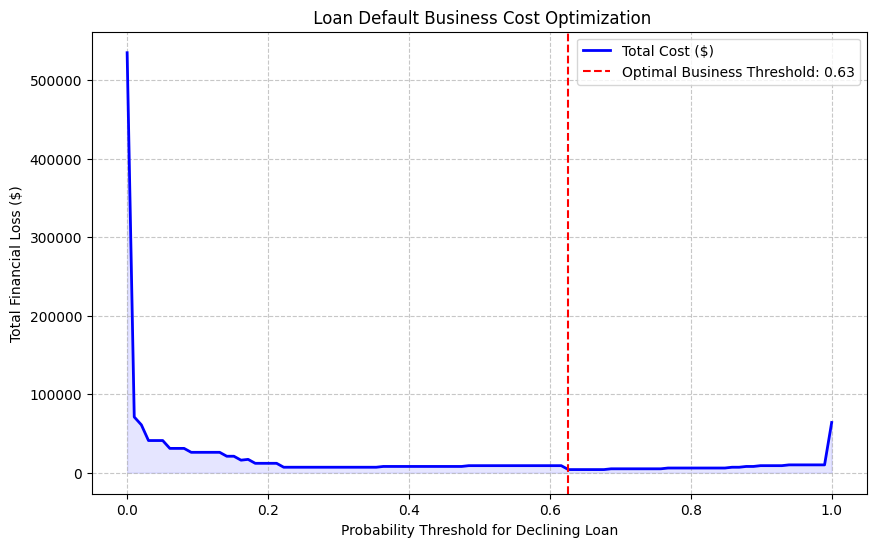

Minimum Business Cost: $4000
Optimal Threshold: 0.63


In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score

# 1. Load Data & Simulate Loan Default Scenario
# We use this reliable dataset but rename columns to match Task 4 requirements
data = load_breast_cancer()
df = pd.DataFrame(data.data, columns=data.feature_names)
# Target: 1 = Default (Minority), 0 = Repaid (Majority)
df['TARGET'] = (data.target == 0).astype(int)

X = df.drop(columns=['TARGET'])
y = df['TARGET']

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# 2. Train XGBoost Model
# scale_pos_weight compensates for the imbalance of defaulters
model = XGBClassifier(n_estimators=100, scale_pos_weight=5, eval_metric='logloss')
model.fit(X_train, y_train)

# Get probabilities of 'Default' (Class 1)
y_probs = model.predict_proba(X_test)[:, 1]

# 3. Business Cost Optimization Logic
# Define the asymmetric costs:
cost_fp = 5000  # Cost of False Positive: Lending to a defaulter (Loss of Principal)
cost_fn = 1000  # Cost of False Negative: Rejecting a good payer (Loss of Interest)

thresholds = np.linspace(0, 1, 100)
total_business_costs = []

for t in thresholds:
    y_pred = (y_probs >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    # Calculate total financial impact
    cost = (fp * cost_fp) + (fn * cost_fn)
    total_business_costs.append(cost)

# Find the threshold that results in the minimum cost
optimal_idx = np.argmin(total_business_costs)
optimal_threshold = thresholds[optimal_idx]
min_cost = total_business_costs[optimal_idx]

# 4. Visualization

plt.figure(figsize=(10, 6))
plt.plot(thresholds, total_business_costs, color='blue', lw=2, label='Total Cost ($)')
plt.axvline(optimal_threshold, color='red', linestyle='--',
            label=f'Optimal Business Threshold: {optimal_threshold:.2f}')
plt.fill_between(thresholds, total_business_costs, alpha=0.1, color='blue')
plt.title(' Loan Default Business Cost Optimization')
plt.xlabel('Probability Threshold for Declining Loan')
plt.ylabel('Total Financial Loss ($)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

print(f"Minimum Business Cost: ${min_cost}")
print(f"Optimal Threshold: {optimal_threshold:.2f}")